In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tf_keras as keras  
from tf_keras import layers
from tf_keras import Sequential
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tf_keras import Model
from tf_keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
mse_loss = MeanSquaredError()

from Forcasting_lib import load_fred_data, make_stationary, standardize_data

# TensorFlow Probability
tfd = tfp.distributions
tfpl = tfp.layers


In [2]:
## load and transform data
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

Datei './Data/FRED_QD_Data.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


### Implement time series

In [ ]:
def evaluate_BNN_epistemic(data_scaled, window_length=5, hidden_layer_sizes=32, initial_window=100, n_samples=100):
    n_total = len(data_scaled)

    y_preds_mean = []
    y_preds_lower = []
    y_preds_upper = []
    y_trues = []

    for i in range(initial_window, n_total - 1):
        train_data = data_scaled[:i]

        # Sequences erstellen
        X_train, y_train = [], []
        for j in range(window_length, len(train_data)):
            X_train.append(train_data[j - window_length:j])
            y_train.append(train_data[j, 0])  # Ziel: GDPC1

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # BNN-Modell (nur epistemische Unsicherheit)
        model = keras.Sequential([
            keras.Input(shape=(window_length, data_scaled.shape[1])),
            layers.Flatten(),
            tfpl.DenseFlipout(hidden_layer_sizes, activation='relu'),
            tfpl.DenseFlipout(1)
        ])

    

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

        # Vorhersage mit n_samples für epistemische Unsicherheit
        x_input = data_scaled[i - window_length:i].reshape(1, window_length, data_scaled.shape[1])
        preds = np.array([model(x_input, training=True).numpy().flatten()[0] for _ in range(n_samples)])

        pred_mean = np.mean(preds)
        ci_lower = np.percentile(preds, 2.5)
        ci_upper = np.percentile(preds, 97.5)

        y_preds_mean.append(pred_mean)
        y_preds_lower.append(ci_lower)
        y_preds_upper.append(ci_upper)

        y_true = data_scaled[i, 0]
        y_trues.append(y_true)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds_mean))

    return rmse, y_preds_mean, y_preds_lower, y_preds_upper, y_trues


In [ ]:
## missing data am Anfang der Zeitreihe kann Problemlus verursachen
## wäre aber besser da einen test zu bauen der die Daten auf NaN prüft
## grade Kein Porblem aber langrfristig wünschenswert
data = df_std[cols_to_standardize].dropna().values
rmse, y_mean, y_low, y_up, y_true = evaluate_BNN_epistemic(data, initial_window=150)

NameError: name 'df_std' is not defined

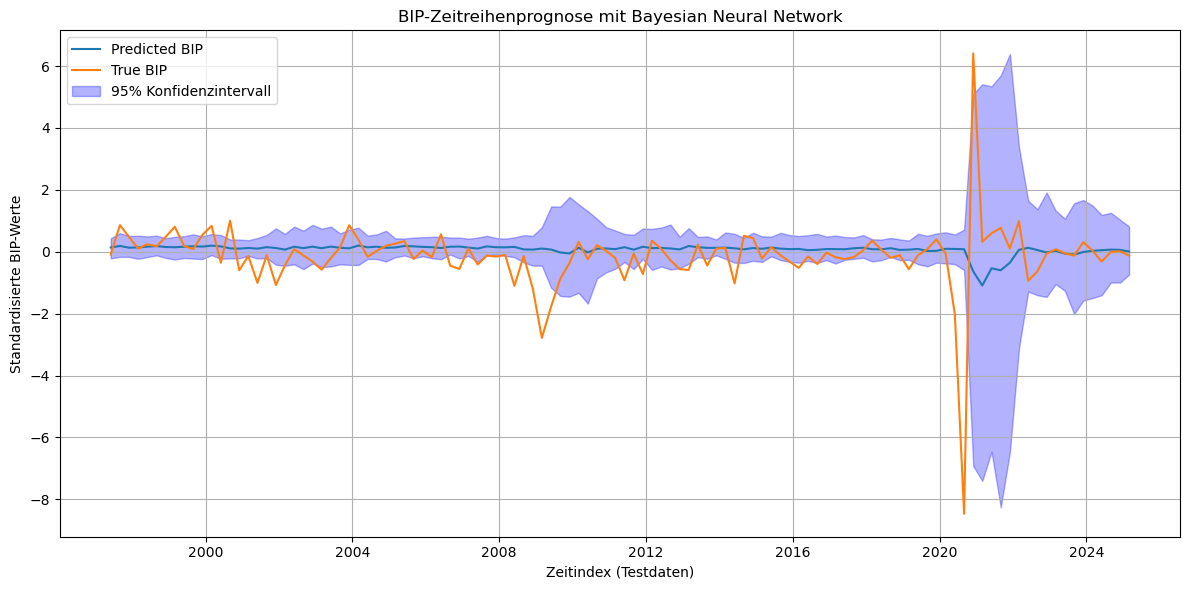

In [ ]:
# Ergebnis-Plot
dates = df_std[cols_to_standardize].dropna().index[-len(y_mean):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, y_mean, label="Predicted BIP")
plt.plot(dates, y_true, label="True BIP")
plt.fill_between(
    dates,
    y_low,
    y_up,
    color="blue",
    alpha=0.3,
    label="95% Konfidenzintervall"
)
plt.legend()
plt.title("BIP-Zeitreihenprognose mit Bayesian Neural Network")
plt.xlabel("Zeitindex (Testdaten)")
plt.ylabel("Standardisierte BIP-Werte")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_mean):],
    'y_true': y_true,
    'y_pred': y_mean,
    'lower_bound': y_low,
    'upper_bound': y_up
})
results_df.to_csv('./Data/results/BNN_forecast_results.csv', index=True)

### Nutze größeren Prädiktoren Satz

In [7]:
cols_to_standardize = [
    'GDPC1',      # Reales BIP, Zielvariable
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'TB3MS',       # Rendite 3-monatiger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500',    # S&P 500 Index
    'PCECC96',    # PCE-Kerninflation
    'GPDIC1',     # Bruttoinlandsinvestitionen (real)
    'PNFIx',      # Private nichtwohnwirtschaftliche Investitionen
    'FPIx',       # Ausrüstungsinvestitionen
    'PCDGx',      # Konsum langlebiger Güter
    'PCNDx',      # Konsum nicht langlebiger Güter
    'PCESVx',     # Konsum von Dienstleistungen
    'CE16OV',     # Zivilbeschäftigung
    'CPIAUCSL',   # Verbraucherpreisindex (CPI)
    'PCEPILFE'    # PCE-Kerninflation
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

## Daten vorbereiten
data_all = df_std[cols_to_standardize].dropna()

# Ziel und Prädiktoren trennen
y_all = data_all["GDPC1"]
X_all = data_all.drop(columns=["GDPC1"])  

Standardisierung abgeschlossen.


In [8]:
data = df_std[cols_to_standardize].dropna().values
rmse, y_mean, y_low, y_up, y_true = evaluate_BNN_epistemic(data, initial_window=150)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variabl

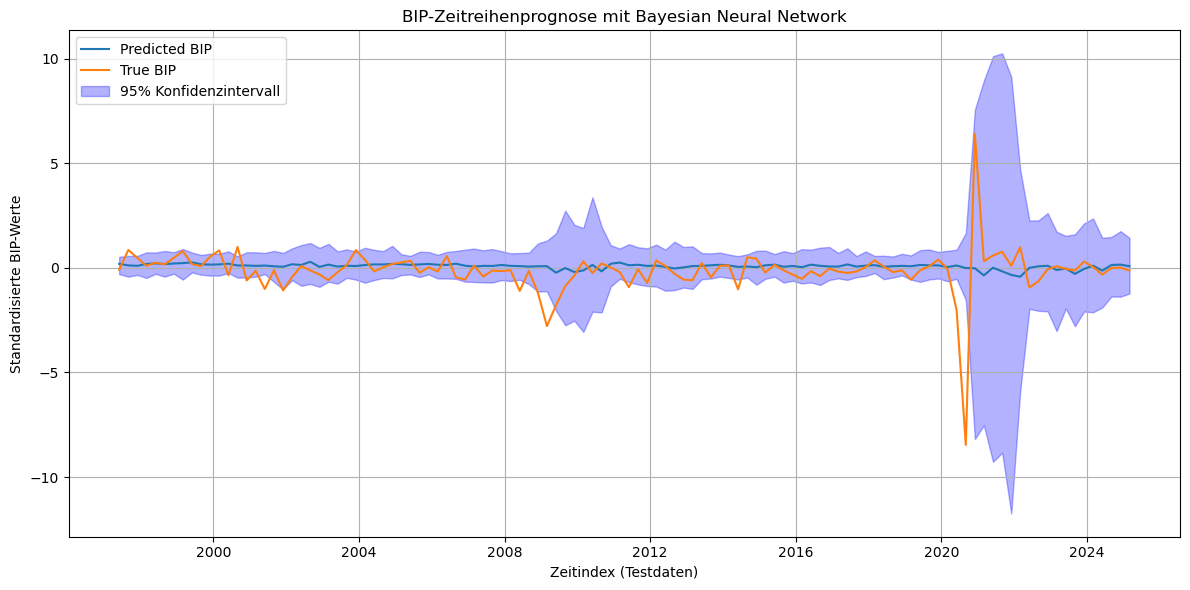

In [9]:
# Ergebnis-Plot
dates = df_std[cols_to_standardize].dropna().index[-len(y_mean):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, y_mean, label="Predicted BIP")
plt.plot(dates, y_true, label="True BIP")
plt.fill_between(
    dates,
    y_low,
    y_up,
    color="blue",
    alpha=0.3,
    label="95% Konfidenzintervall"
)
plt.legend()
plt.title("BIP-Zeitreihenprognose mit Bayesian Neural Network")
plt.xlabel("Zeitindex (Testdaten)")
plt.ylabel("Standardisierte BIP-Werte")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_mean):],
    'y_true': y_true,
    'y_pred': y_mean,
    'lower_bound': y_low,
    'upper_bound': y_up
})
results_df.to_csv('./Data/results/BNN_forecast_2_results.csv', index=True)